In [1]:
import os
import sys
import argparse

from astropy.table import Table, join
from datasets import load_dataset
import h5py
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from math import pi
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import matplotlib.pyplot as plt

from utils.helpers import zero_shot_train, few_shot_train, plot_radar, resnet_r2, photometry_r2, spender_r2
from utils.models import SimpleMLP

# Rewritten with CUDA support
from pyro.distributions.transforms import ComposeTransform
import torch
import pyro
import pyro.distributions as dist
import pyro.distributions.transforms as T
from torch.distributions.transforms import Transform
from torch.distributions.utils import lazy_property
from pyro.distributions import constraints
import tqdm

sns.set_style("ticks")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2})

# Overall Definitions:
properties = ['Z_HP', 'LOG_MSTAR', 'Z_MW', 't_ageMW', 'SFR']
property_titles = ['$Z_{HP}$', '$\log {M_\star}$', '$\log Z_{MW}$', '$t_{age}$', '$\log sSFR$']
scaler = StandardScaler()

# ----- Replace with new Dataset Loader ----- #
def get_embeddings(embedding_file, source='images'):
    CLIP_embeddings = h5py.File(embedding_file, 'r') 
    train_embeddings = CLIP_embeddings['train']
    test_embeddings  = CLIP_embeddings['test']
    
    if source == 'images':
        train_table = Table({'targetid': train_embeddings['targetid'], 
                             'image_features': train_embeddings['image_features']})

        test_table  = Table({'targetid': test_embeddings['targetid'], 
                             'image_features': test_embeddings['image_features']})
    
    elif source == 'spectra':
        train_table = Table({'targetid': train_embeddings['targetid'], 
                             'spectra_features': train_embeddings['spectra_features']})

        test_table  = Table({'targetid': test_embeddings['targetid'], 
                             'spectra_features': test_embeddings['spectra_features']})
        
    elif source == 'photometry':
        train_table = Table({'targetid': train_embeddings['targetid']}) 
        test_table  = Table({'targetid': test_embeddings['targetid']})
    
    return train_table, test_table

def get_provabgs(embedding_file, source='images'):    
    provabgs = Table.read('/mnt/home/lparker/ceph/BGS_ANY_full.provabgs.sv3.v0.hdf5')
    provabgs = provabgs[(provabgs['LOG_MSTAR'] > 0) * (provabgs['MAG_G'] > 0) * (provabgs['MAG_R'] > 0) * (provabgs['MAG_Z'] > 0)]
    inds = np.random.permutation(len(provabgs))
    provabgs = provabgs[inds]

    if source == 'images':
        train_table, test_table = get_embeddings(embedding_file, source)
        train_provabgs = join(provabgs, train_table, keys_left='TARGETID', keys_right='targetid')
        test_provabgs  = join(provabgs, test_table, keys_left='TARGETID', keys_right='targetid')
    
    elif source == 'spectra':
        train_table, test_table = get_embeddings(embedding_file, source)
        train_provabgs = join(provabgs, train_table, keys_left='TARGETID', keys_right='targetid')
        test_provabgs  = join(provabgs, test_table, keys_left='TARGETID', keys_right='targetid')

    elif source == 'photometry':
        train_table, test_table = get_embeddings(embedding_file, source)
        train_provabgs = join(provabgs, train_table, keys_left='TARGETID', keys_right='targetid')
        test_provabgs  = join(provabgs, test_table, keys_left='TARGETID', keys_right='targetid')
    
    return train_provabgs, test_provabgs
# -------------------------------------------- #

def get_data(embedding_file, source='images'):
    train_provabgs, test_provabgs = get_provabgs(embedding_file, source)
    
    # Scale the galaxy property data
    prop_scalers = {}
    y_train, y_test = np.zeros((len(train_provabgs), 5)), np.zeros((len(test_provabgs), 5))
    for i, p in enumerate(properties):
        prop_train, prop_test = train_provabgs[p].reshape(-1, 1), test_provabgs[p].reshape(-1, 1)
        if p == 'Z_MW': prop_train, prop_test = np.log(prop_train), np.log(prop_test)
        prop_scaler = StandardScaler().fit(prop_train)    
        prop_train, prop_test = prop_scaler.transform(prop_train), prop_scaler.transform(prop_test)
        y_train[:, i], y_test[:, i] = prop_train.squeeze(), prop_test.squeeze()
        prop_scalers[p] = prop_scaler
    
    if source == 'images':
        train_images, test_images = train_provabgs['image_features'], test_provabgs['image_features']
        image_scaler = StandardScaler().fit(train_images)
        train_images, test_images = image_scaler.transform(train_images), image_scaler.transform(test_images)
    
        data= {'X_train': torch.tensor(train_images),
               'X_test': torch.tensor(test_images),
               'y_train': torch.tensor(y_train, dtype=torch.float32),
               'y_test': torch.tensor(y_test, dtype=torch.float32)}
        
    elif source == 'spectra':
        train_spectra, test_spectra = train_provabgs['spectra_features'], test_provabgs['spectra_features']
        spectrum_scaler = StandardScaler().fit(train_spectra)
        train_spectra, test_spectra = spectrum_scaler.transform(train_spectra), spectrum_scaler.transform(test_spectra)
        
        data = {'X_train': torch.tensor(train_spectra),
                'X_test': torch.tensor(test_spectra),
                'y_train': torch.tensor(y_train, dtype=torch.float32),
                'y_test': torch.tensor(y_test, dtype=torch.float32)}
        
    elif source == 'photometry':
        data = {'X_train': torch.tensor(train_provabgs['MAG_G', 'MAG_R', 'MAG_Z'], dtype=torch.float32),
                'X_test': torch.tensor(test_provabgs['MAG_G', 'MAG_R', 'MAG_Z'], dtype=torch.float32),
                'y_train': torch.tensor(y_train, dtype=torch.float32),  
                'y_test': torch.tensor(y_test, dtype=torch.float32)}
        
    else:
        raise ValueError('Invalid source. Must be one of: images, spectra, photometry')
    
    return data, prop_scalers

def get_supervised(source):
    if source == 'resnet':
        resnet_results = torch.load('./baseline_models/resnet_results')
        data = {'X_train': torch.tensor(resnet_results['train_preds']),
                'y_train': torch.tensor(resnet_results['train_trues']),
                'X_test': torch.tensor(resnet_results['test_preds']),
                'y_test': torch.tensor(resnet_results['test_trues'])}
        scalers = resnet_results['scalers']
    
    elif source == 'spender':
        spender_results = torch.load('./baseline_models/spender_results')
        data = {'X_train': torch.tensor(spender_results['train_preds']),
                'y_train': torch.tensor(spender_results['train_trues']),
                'X_test': torch.tensor(spender_results['test_preds']),
                'y_test': torch.tensor(spender_results['test_trues'])}
        scalers = spender_results['scalers']
        
    else:
        raise ValueError('Invalid source. Must be one of: resnet, spender')
    
    return data, scalers

class ConditionalFlowStack(dist.conditional.ConditionalComposeTransformModule):
    def __init__(self, input_dim, context_dim, hidden_dims, num_flows):
        
        coupling_transforms = [
            T.conditional_spline(input_dim, context_dim, count_bins=16, hidden_dims=hidden_dims, order='quadratic').cuda()
            for _ in range(num_flows)
        ]
        
        super().__init__(coupling_transforms, cache_size=1)

def train(train_loader, test_loader, val_loader, base_dist, transform, index, num_epochs=100, lr=5e-5):
    # Initialize the optimizer
    optimizer = torch.optim.Adam(transform.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)
    pyro.clear_param_store()

    train_losses, val_losses = [], []
    epochs = tqdm.trange(num_epochs, desc='Training flow %i' % (index))
    best_val_loss, best_transform = float('inf'), None

    for epoch in epochs:  
        avg_loss = 0
        for X, y in train_loader:
            optimizer.zero_grad()
            flow_dist = dist.conditional.ConditionalTransformedDistribution(base_dist, [transform]).condition(X.to('cuda'))
            train_loss = -flow_dist.log_prob(y.to('cuda')).mean()
            train_loss.backward()
            optimizer.step()
            flow_dist.clear_cache()
            avg_loss += train_loss.item()  
        avg_loss /= len(train_loader)

        avg_val_loss = 0
        with torch.no_grad():
            for X, y in val_loader:
                flow_dist = dist.conditional.ConditionalTransformedDistribution(base_dist, [transform]).condition(X.to('cuda'))
                avg_val_loss -= flow_dist.log_prob(y.to('cuda')).mean().item()
                flow_dist.clear_cache()
        avg_val_loss /= len(val_loader)

        # add early stopping
        if epoch > 20 and avg_val_loss > np.mean(val_losses[-20:]):
            break
        
        train_losses.append(avg_loss)
        val_losses.append(avg_val_loss)

        epochs.set_description("step: {}, train loss: {}, val loss: {}".format(epoch, np.round(avg_loss, 3), np.round(avg_val_loss, 3)))
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_transform = transform
        
        scheduler.step()
    
    avg_test_loss = 0
    for X, y in test_loader:
        flow_dist = dist.conditional.ConditionalTransformedDistribution(base_dist, [best_transform]).condition(X.to('cuda'))
        avg_test_loss -= flow_dist.log_prob(y.to('cuda')).mean()
        flow_dist.clear_cache()
    avg_test_loss /= len(test_loader)
        
    return best_transform, avg_test_loss

def do_flow(data, num_ndes, n_samples=500, max_hidden=128, max_flows=4, min_flows=None, num_epochs=100, lr=5e-5, batch_size=1024):

    if min_flows == None: min_flows = max_flows - 2

    X_train, X_test = data['X_train'].to('cuda'), data['X_test'].to('cuda')
    y_train, y_test = data['y_train'].to('cuda'), data['y_test'].to('cuda')

    X_train, X_val, y_train, y_val = X_train[:int(0.8*len(X_train))], X_train[int(0.8*len(X_train)):], y_train[:int(0.8*len(y_train))], y_train[int(0.8*len(y_train)):]

    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size)
    val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size)
    test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size)

    input_dim, context_dim = y_train.shape[1], X_train.shape[1]

    base_dist = dist.Normal(torch.zeros(input_dim).to('cuda'), torch.ones(input_dim).to('cuda'))
    
    flows, losses, samples = [], [], []
    for i in range(num_ndes):
        nhidden = int(np.ceil(np.exp(np.random.uniform(np.log(max_hidden/4), np.log(max_hidden)))))
        nblocks = int(np.random.uniform(min_flows, max_flows))

        print('Flow with nhidden=%i; ncomponents=%i:' % (nhidden, nblocks))

        transform = ConditionalFlowStack(input_dim, context_dim, [nhidden, nhidden, nhidden], nblocks).to('cuda')
        flow, loss = train(train_loader, test_loader, val_loader, base_dist, transform, i, num_epochs=num_epochs, lr=lr)
        print('Test Loss: %.3f' % (loss))
        flows.append(flow)
        losses.append(loss)

        print('Sampling flow...')
        flow_samples = torch.zeros((X_test.shape[0], 1000, 5))
        with torch.no_grad():   
            for i, x in enumerate(X_test):
                flow_dist = dist.conditional.ConditionalTransformedDistribution(base_dist, [flow]).condition(x) 
                flow_samples[i, :, :] = flow_dist.sample(torch.Size([n_samples,])).detach().cpu()

        samples.append(flow_samples)
        print('')
        
    return flows, losses, samples

def do_flow_each_dim(data, num_ndes, n_samples=1000, max_hidden=128, max_flows=1, min_flows=1, num_epochs=100, lr=5e-5, batch_size=1024):
    full_flows, full_losses, full_samples = {}, {}, {}
    for i, prop in enumerate(properties):
        print('Training flow for %s...' % (prop))
        
        prop_data = data.copy()
        prop_data['y_train'] = data['y_train'][:, i].reshape(-1, 1)
        prop_data['y_test'] = data['y_test'][:, i].reshape(-1, 1)

        flows, losses, samples = do_flow(prop_data, num_ndes, n_samples=n_samples, max_hidden=max_hidden, max_flows=max_flows, min_flows=min_flows, num_epochs=num_epochs, lr=lr, batch_size=batch_size)
        
        full_flows[prop] = flows
        full_losses[prop] = losses
        full_samples[prop] = samples
        print('')

    return full_flows, full_losses, full_samples

/mnt/sw/nix/store/b4q5asj8flwlgmaijgj1r6wbmnls5x8k-python-3.9.15-view/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /mnt/sw/nix/store/7bjp92vyxq4vmcm6q2kwdv325d50n362-py-torchvision-0.14.1/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


In [30]:
# Data Files
embedding_file = '/mnt/home/lparker/ceph/good_embeddings/newest_embeddings.h5py'
stein_embedding_file='/mnt/home/lparker/ceph/stein_propertyembeddings.h5'
DINO_embedding_file='/mnt/home/lparker/ceph/DINO_embeddings.h5'
GalFormer_embedding_file='/mnt/home/lparker/ceph/GalFormer_embeddings.h5'

datasets = {'images': {}, 'spectra': {}, 'photometry': {}}

# Load the data
print('Loading Data...')
datasets['images']['clip'], img_scalers = get_data(embedding_file, source='images')
datasets['images']['stein'], _ = get_data(stein_embedding_file, source='images')
datasets['images']['dino'], _ = get_data(DINO_embedding_file, source='images')
datasets['images']['resnet'], _ = get_supervised('resnet')

datasets['spectra']['clip'], spec_scalers = get_data(embedding_file, source='spectra')
datasets['spectra']['spender'], _ = get_supervised('spender')
datasets['spectra']['GalFormer'], _ = get_data(GalFormer_embedding_file, source='spectra')

datasets['photometry']['mlp'], _ = get_data(embedding_file, source='photometry')
print('')

Loading Data...



In [31]:
def expected_coverage_drp(samples, theta, references='random', metric='euclidean'):
    """
    Compute the coverage of a set of samples using DRP regions.
    
    Parameters:
    -----------
    samples: array-like, shape (n_sims, n_samples, n_dims)
        The samples to compute the coverage of.
    theta: array-like, shape (n_sims, n_dims)
        The true parameter values for each samples.
    references: array-like, shape (n_references, n_sims) or 'random'
        The reference points to use for the DRP regions. If 'random', then
        the reference points are chosen randomly from the parameter space.
    metric: string
        The metric to use when computing the distance. Can be 'euclidean' or
        'manhattan'.
        
    Returns:
    --------
    alpha: array-like, 
        Credibility values
    ecp: array-like,
        Expected coverage probability
    """

    samples = samples.permute(1, 0, 2).detach().cpu().numpy()
    theta = theta.detach().cpu().numpy()

    # Check that shapes are correct
    assert len(samples.shape) == 3, "samples must be a 3D array"
    assert len(theta.shape) == 2, "theta must be a 2D array"

    num_samples = samples.shape[0]
    num_sims = samples.shape[1]
    num_dims = samples.shape[2]

    assert theta.shape[0] == num_sims, "theta must have the same number of rows as samples"
    assert theta.shape[1] == num_dims, "theta must have the same number of columns as samples"

    # Reshape theta
    theta = theta[np.newaxis, :, :]

    # Normalize
    low = np.min(theta, axis=1, keepdims=True)
    high = np.max(theta, axis=1, keepdims=True)

    # Generate reference points
    if isinstance(references, str) and references == 'random':
        references = np.random.uniform(low=0, high=1, size=(num_sims, num_dims))
        #references = x_test
    else:
        assert len(references.shape) == 2, "references must be a 2D array"
        assert references.shape[0] == num_sims, "references must have the same number of rows as samples"
        assert references.shape[1] == num_dims, "references must have the same number of columns as samples"

    # Compute distances
    if metric == 'euclidean':
        samples_distances = np.sqrt(np.sum((references[np.newaxis] - samples) ** 2, axis=-1))
        theta_distances = np.sqrt(np.sum((references - theta) ** 2, axis=-1))
    elif metric == 'manhattan':
        samples_distances = np.sum(np.abs(references[np.newaxis] - samples), axis=-1)
        theta_distances = np.sum(np.abs(references - theta), axis=-1)
    else:
        raise ValueError("metric must be either 'euclidean' or 'manhattan'")

    # Compute coverage
    f = np.sum((samples_distances < theta_distances), axis=0) / num_samples

    # Compute expected coverage
    h, alpha = np.histogram(f, density=True, bins=num_sims//10)
    dx = alpha[1] - alpha[0]
    ecp = np.cumsum(h)*dx
    return ecp, alpha[1:]

In [32]:
def plot_coverage(source, method):
    fig, ax = plt.subplots(1, 5, figsize=(20, 4))
    samples = torch.cat(torch.load(f'flows/{source}/new_{method}_samples.pt'), dim=1)

    for i in range(5):
        #for j in range(len(samples)):
            ecp, alpha = expected_coverage_drp(samples[:, :, i][:, :, np.newaxis], datasets[source][method]['y_test'][:, i][:, np.newaxis], references='random', metric='euclidean')
            ax[i].plot(alpha, ecp, alpha=1.0, color='blue')
            ax[i].set_title(property_titles[i])
            ax[i].set_xlabel('Credibility')
            if i == 0: 
                ax[i].set_ylabel(f'Expected Coverage')
            else:
                ax[i].set_yticklabels([])
            ax[i].plot([0, 1], [0, 1], 'k--')

    plt.subplots_adjust(wspace=0.1)
    plt.savefig(f'flows/{source}/{method}.png', dpi=300, bbox_inches='tight')

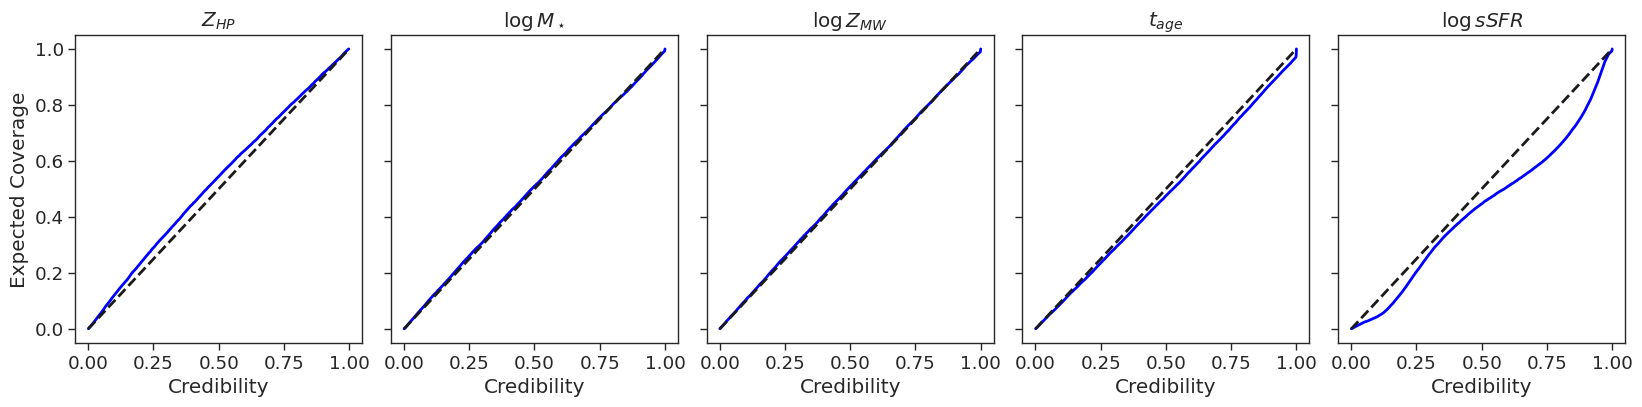

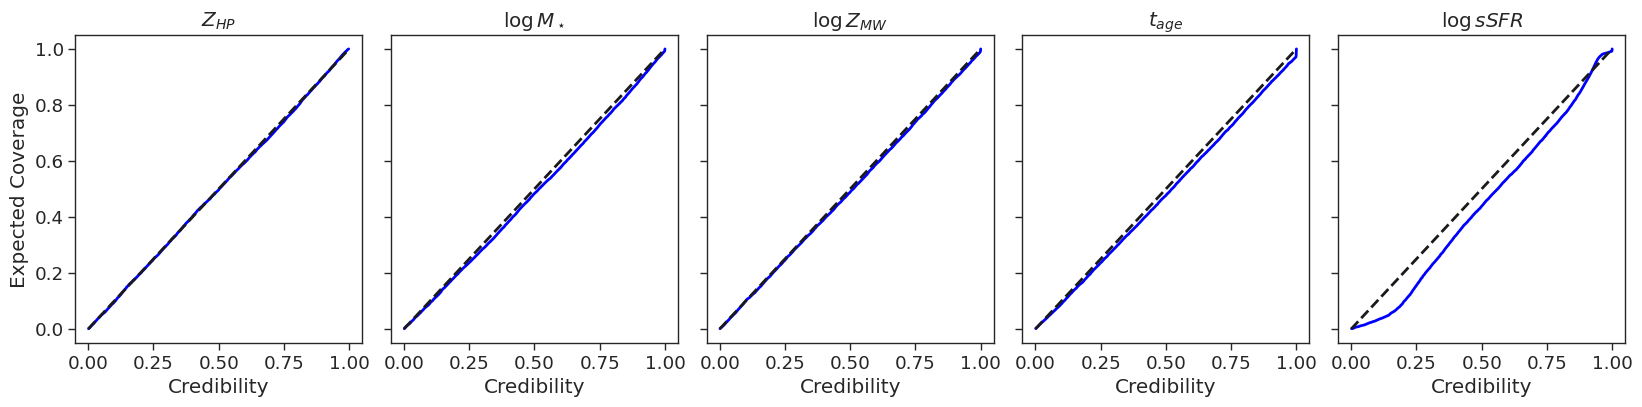

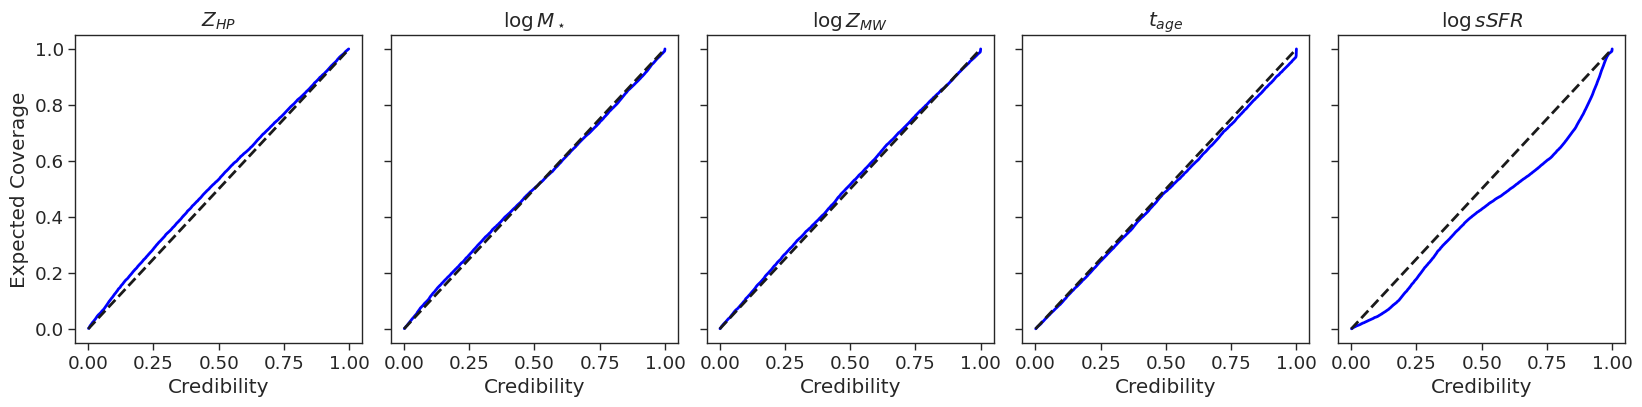

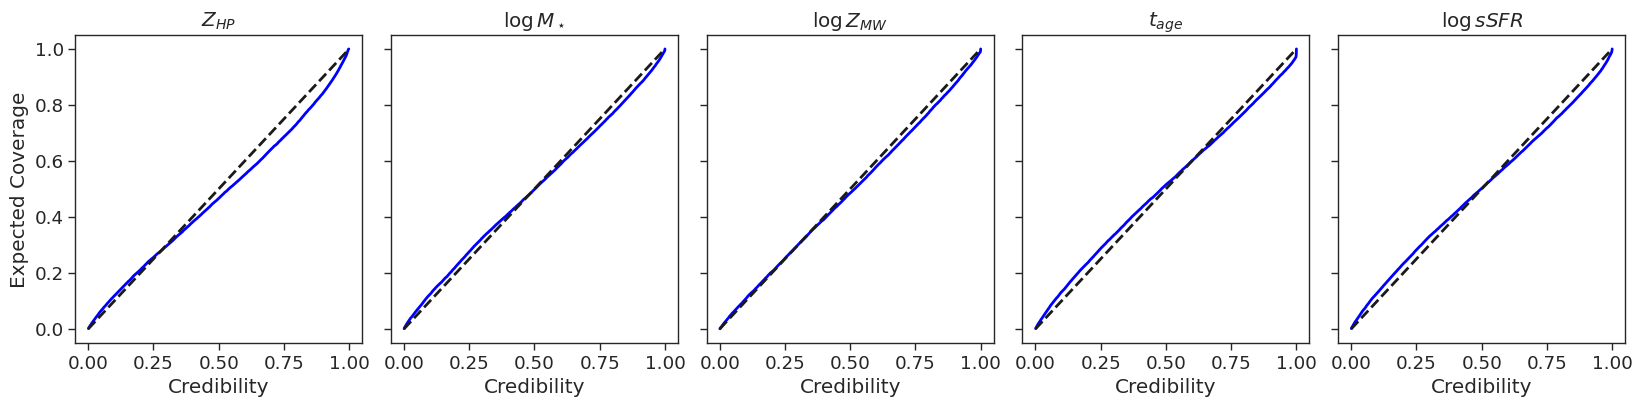

In [33]:
for method in datasets['images'].keys():
    plot_coverage('images', method)

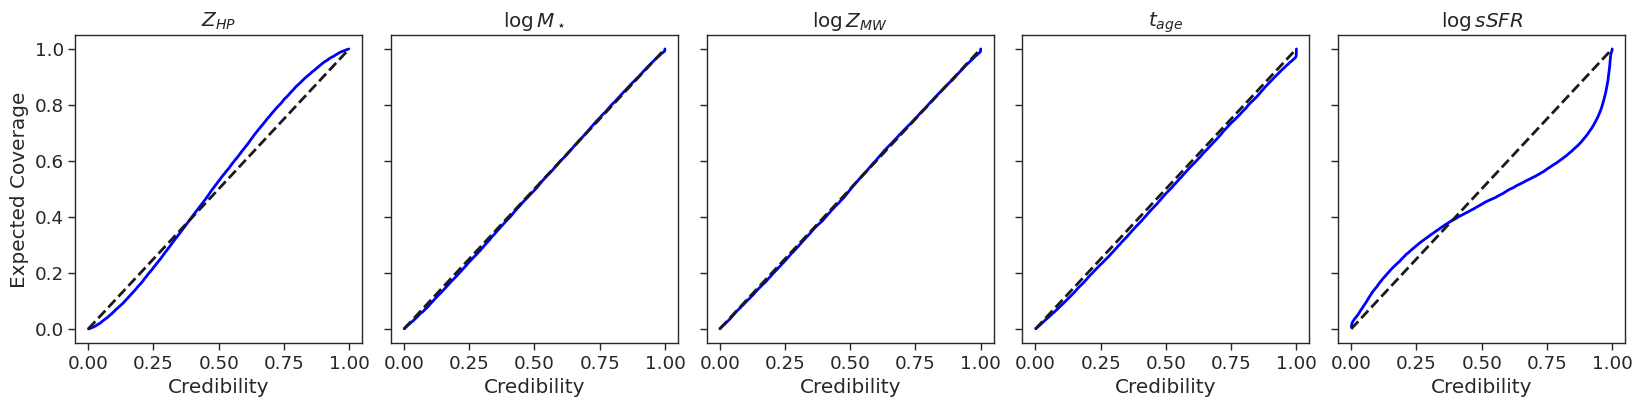

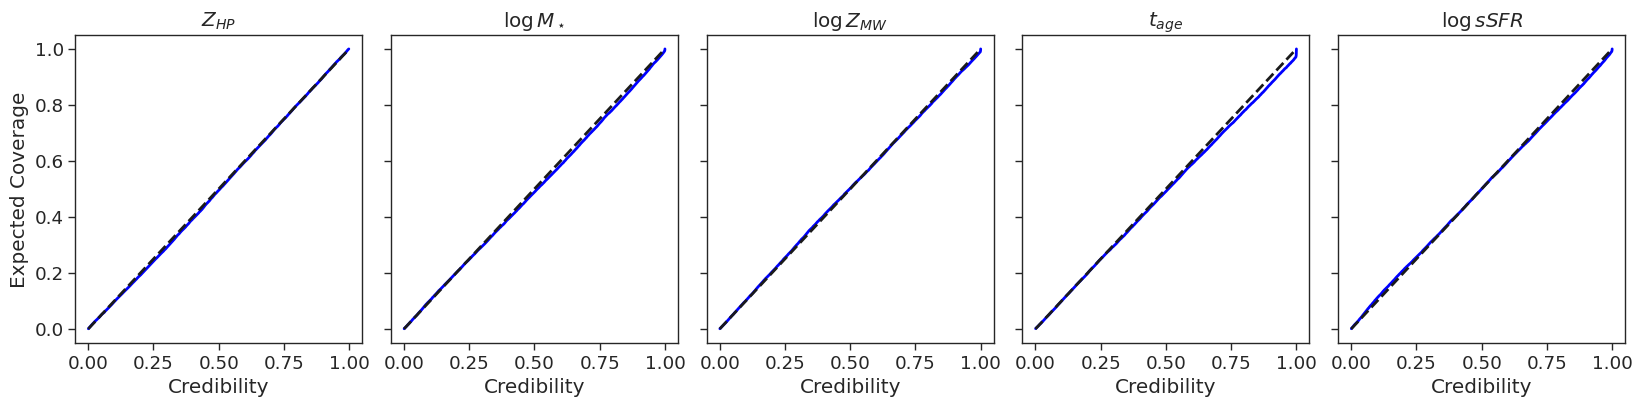

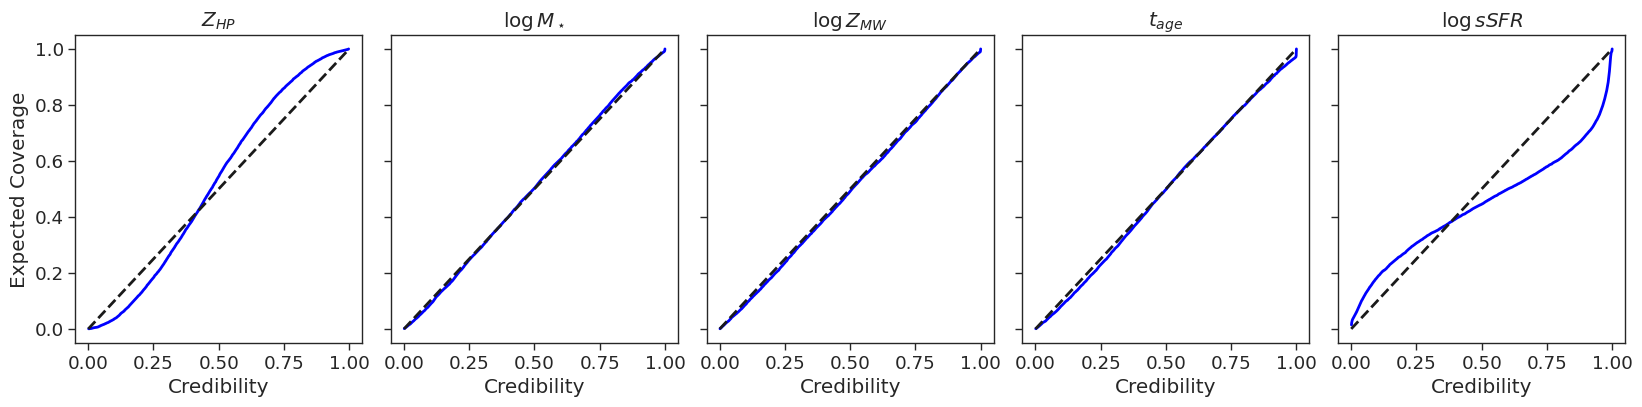

In [34]:
for method in datasets['spectra'].keys():
    plot_coverage('spectra', method)

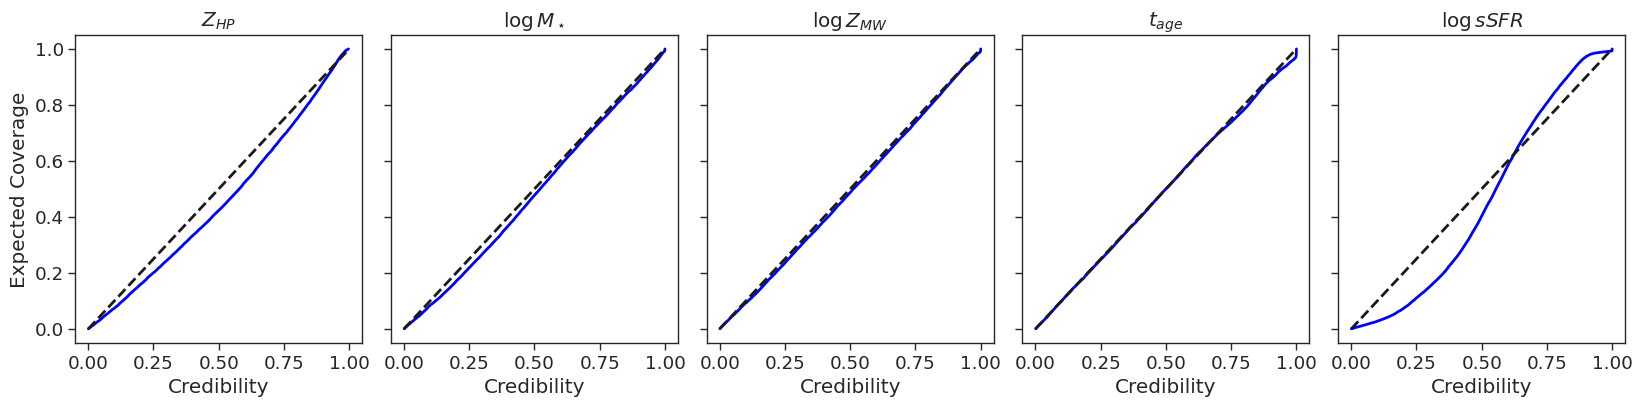

In [35]:
plot_coverage('photometry', 'mlp')

In [62]:
source = 'images'
method = 'clip'

random_index = np.random.randint(0, 20000)

img_samples = torch.cat(torch.load(f'flows/images/clip_samples.pt'), dim=1).detach().cpu().numpy()
spec_samples = torch.cat(torch.load(f'flows/spectra/clip_samples.pt'), dim=1).detach().cpu().numpy()

In [54]:
random_index = np.random.randint(0, 20000)

In [63]:
random_index

379

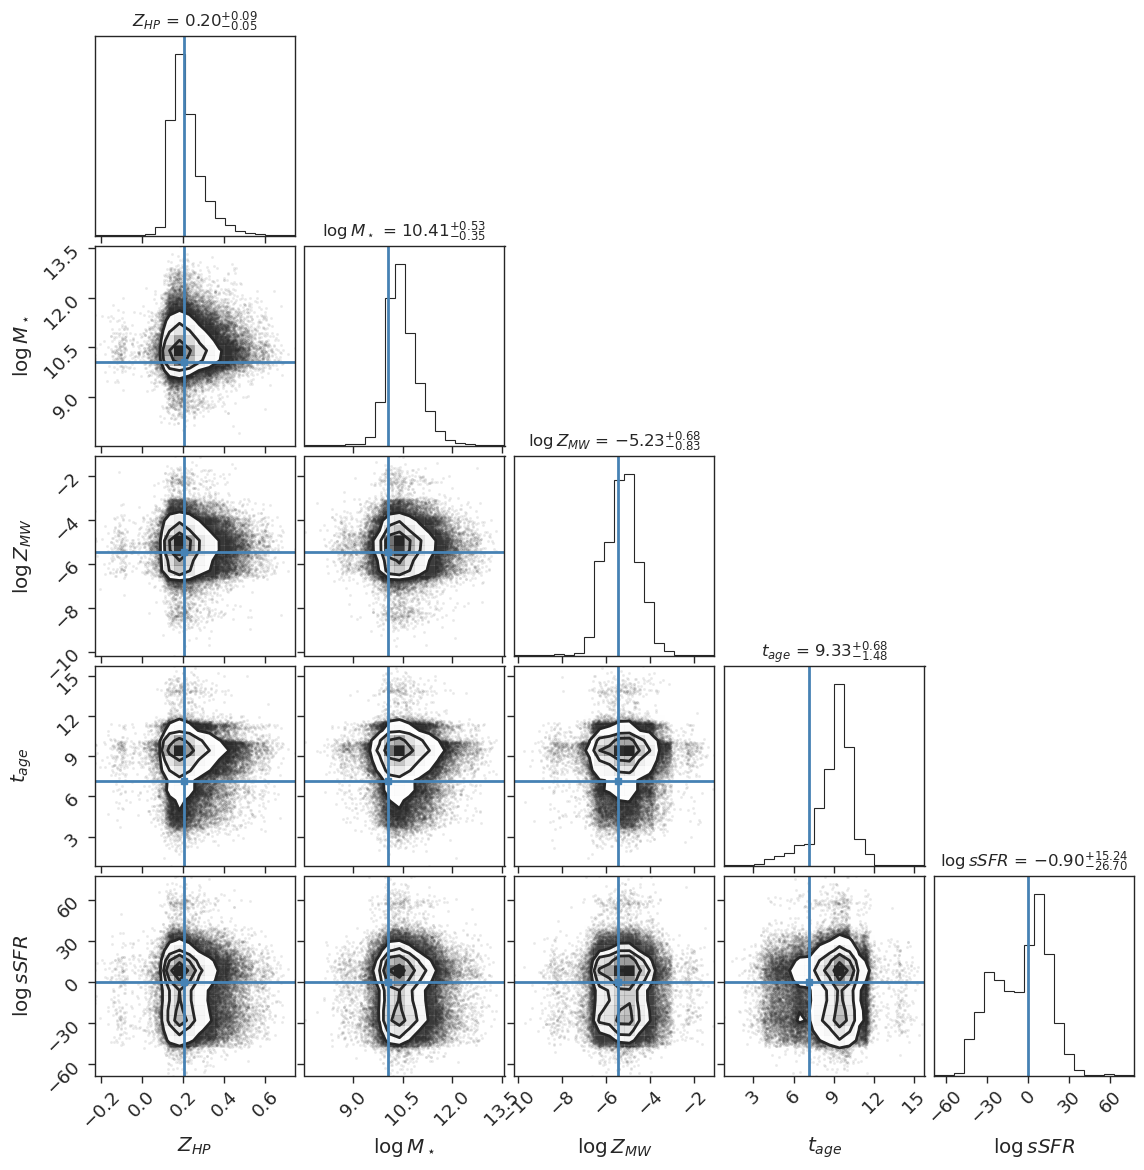

In [64]:
import corner

_img_samples = img_samples[random_index]
truths = datasets['images']['clip']['y_test'][random_index, :].detach().cpu().numpy()

for i, prop in enumerate(properties):
    _img_samples[:, i] = img_scalers[prop].inverse_transform(_img_samples[:, i].reshape(-1, 1)).squeeze()
    truths[i] = img_scalers[prop].inverse_transform(truths[i].reshape(-1, 1)).squeeze()

figure = corner.corner(_img_samples, labels=property_titles, show_titles=True, title_kwargs={"fontsize": 12}, truths=truths)
plt.savefig('flows/images/clip_corner.png', dpi=300, bbox_inches='tight')

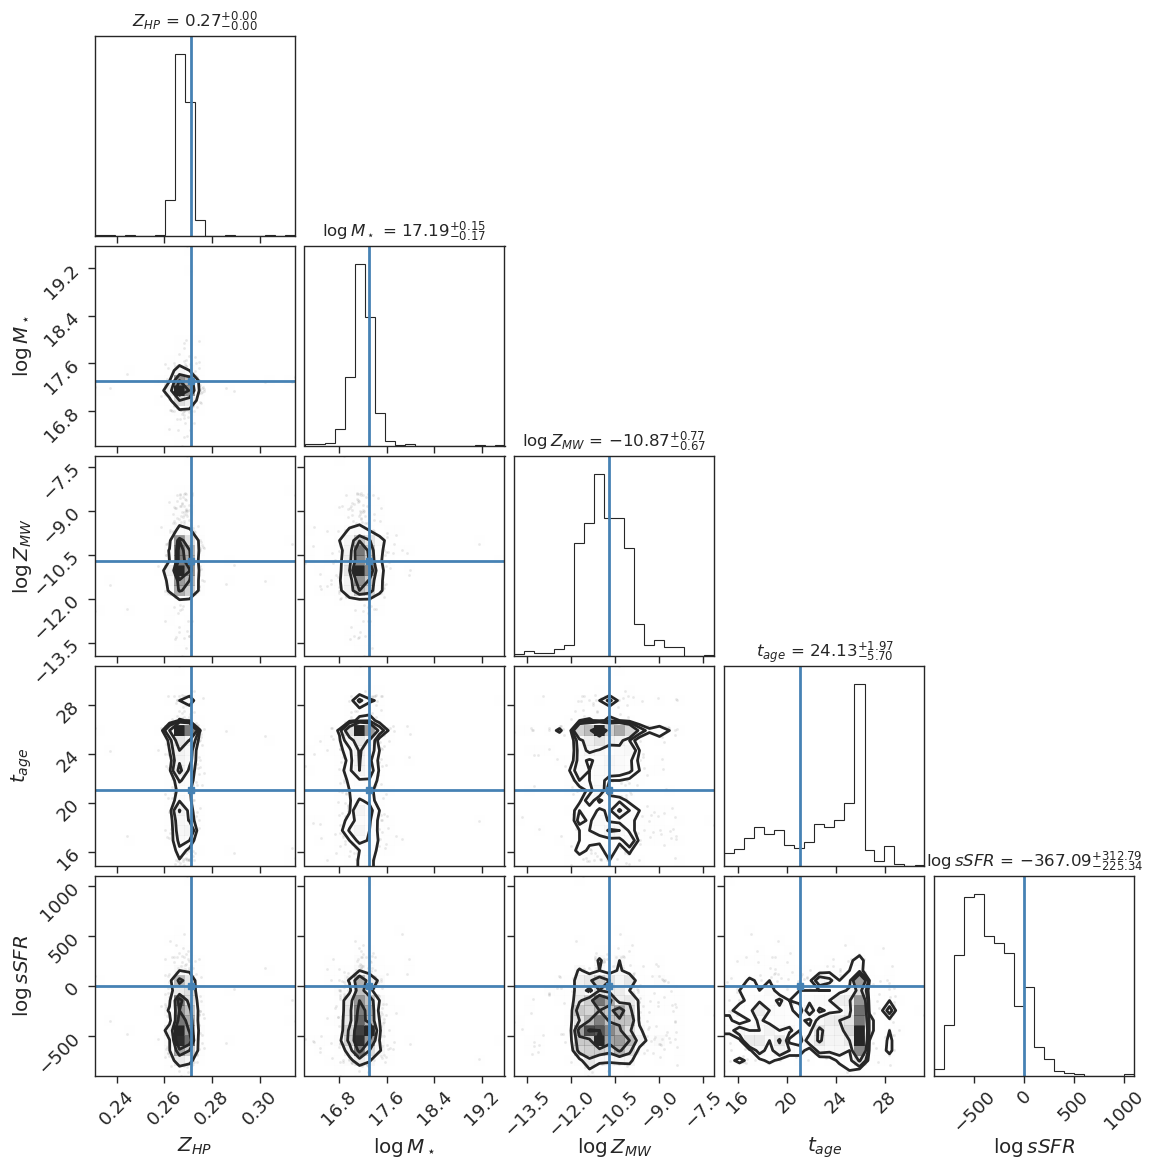

In [69]:
import corner

_spec_samples = spec_samples[random_index]
truths = datasets['spectra']['clip']['y_test'][random_index, :].detach().cpu().numpy()

for i, prop in enumerate(properties):
    _spec_samples[:, i] = spec_scalers[prop].inverse_transform(_spec_samples[:, i].reshape(-1, 1)).squeeze()
    truths[i] = spec_scalers[prop].inverse_transform(truths[i].reshape(-1, 1)).squeeze()

figure = corner.corner(_spec_samples, labels=property_titles, show_titles=True, title_kwargs={"fontsize": 12}, truths=truths)
plt.savefig('flows/spectra/clip_corner.png', dpi=300, bbox_inches='tight')